In [1]:
from jax import numpy as jnp, random, jit
import phayes
import matplotlib.pyplot as plt

In [2]:
from jax.config import config
config.update("jax_enable_x64", True)

# First let's define the unitary matrix/circuit whose eigenphase we want to infer

We'll use the second example from [Moore et al](https://www.chem.purdue.edu/kais/docs/publications/2021/Statistical%20approach%20to%20qpe.pdf) which takes the form $U = P(\pi /4) \otimes (H \cdot R_z(\pi/2) \cdot H)$ where
$$
P(\theta) =
\begin{pmatrix}
1 & 0 \\
0 & e^{i\theta}
\end{pmatrix}
,\qquad
R_z(\theta) =
\begin{pmatrix}
e^{-i\theta / 2} & 0 \\
0 & e^{i\theta / 2}
\end{pmatrix}
,\qquad
H = \frac{1}{\sqrt{2}}
\begin{pmatrix}
1 & 1 \\
1 & -1
\end{pmatrix}
$$

In [3]:
def P(theta):
    return jnp.array([[1, 0], [0, jnp.exp(1.j * theta)]])

def Rz(theta):
    return jnp.array([[jnp.exp(- 0.5j * theta), 0], [0, jnp.exp(0.5j * theta)]])

H = jnp.array([[1, 1], [1, -1]]) / jnp.sqrt(2)

In [4]:
U = jnp.kron(P(jnp.pi / 4), H @ Rz(jnp.pi/2) @ H)

In [5]:
U

Array([[0.70710678+0.j        , 0.        -0.70710678j,
        0.        +0.j        , 0.        +0.j        ],
       [0.        -0.70710678j, 0.70710678+0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.5       +0.5j       , 0.5       -0.5j       ],
       [0.        +0.j        , 0.        +0.j        ,
        0.5       -0.5j       , 0.5       +0.5j       ]],      dtype=complex128)

We'll also get the exact eigenstates and eigenvalues (which we can do since this is a small scale example)

In [6]:
true_eigvals, true_eigvecs = jnp.linalg.eig(U)
phi_ind = 0
phi_vec = true_eigvecs[:, phi_ind]
true_phi = jnp.arccos(true_eigvals[phi_ind].real)
print('True phase:', true_phi)

True phase: 0.7853981633974484


In [7]:
# check true_phi satisfies eigenvector equation
jnp.allclose(U @ phi_vec, jnp.exp(1.j * true_phi) * phi_vec)

Array(True, dtype=bool)

# Now we'll define a protocol for simulating measurements (without noise) from a phase estimation circuit

The (QFT-free) phase estimation circuit has the form

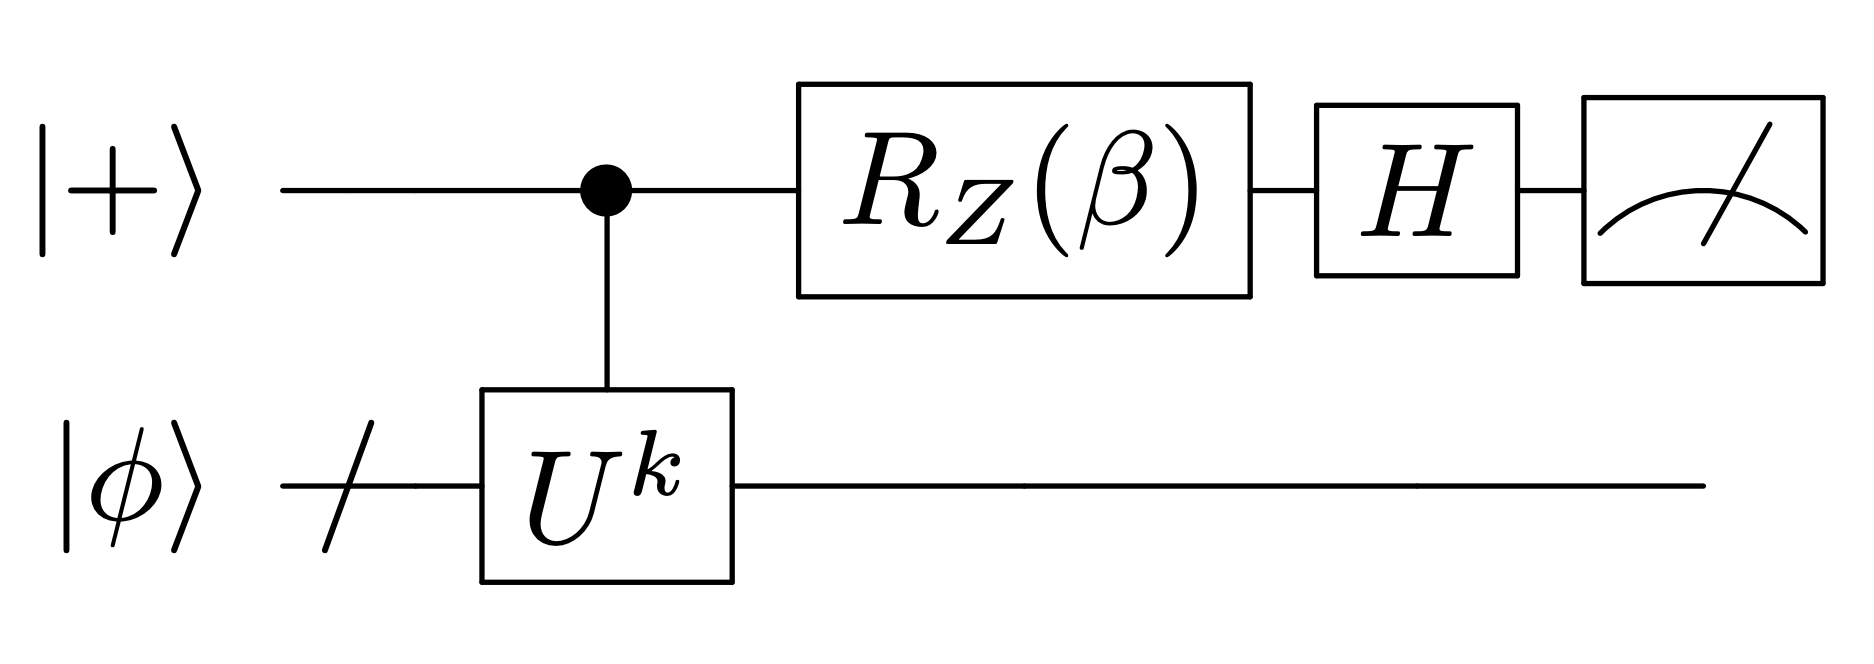

In [8]:
from IPython.display import Image, display
display(Image(filename='hadamard_qpe_circuit.png', embed=True))

In [9]:
N_U = U.shape[0]
n_qubits_U = int(jnp.log2(N_U))

big_H = jnp.kron(H, jnp.eye(N_U))
in_statevector = jnp.kron(jnp.array([1, 0]), phi_vec)

def experiment_probs(k: int, beta: float) -> jnp.ndarray:
    k = int(k)
    big_Rz = jnp.kron(Rz(beta), jnp.eye(N_U))
    U_k = jnp.linalg.matrix_power(U, k)
    controlled_U_k = jnp.block([[jnp.eye(N_U), jnp.zeros(U.shape)], [jnp.zeros(U.shape), U_k]])
    
    out_statevector = big_H @ controlled_U_k @ big_Rz @ big_H @ in_statevector
    measurement_probs = jnp.abs(out_statevector) ** 2
    measurement_probs_q1 = measurement_probs.reshape((2, ) * (n_qubits_U + 1)).sum(axis=tuple(range(1, n_qubits_U + 1)))
    return measurement_probs_q1


def run_experiment(k: int, beta: float, n_shots: int, random_key: random.PRNGKeyArray) -> jnp.ndarray:
    probs = experiment_probs(k, beta)
    return random.choice(random_key, a=jnp.arange(2), p=probs, shape=(n_shots,))

In a real phase estimation experiment, this `run_experiment` function would be replaced with a call to a quantum device implementing the above circuit

In [10]:
# check experiment_probs gives correct likelihood
k_test = 4
beta_test = 0.43543
jnp.isclose(experiment_probs(k_test, beta_test)[0], 0.5 * (1 + jnp.cos(k_test * true_phi + beta_test)))

Array(True, dtype=bool)

In [11]:
# check samples give correct likelihood
shots = run_experiment(k_test, beta_test, 10000, random.PRNGKey(0))
jnp.isclose(1 - shots.mean(), 0.5 * (1 + jnp.cos(k_test * true_phi + beta_test)), atol=1e-2)

Array(True, dtype=bool)

# Now we can run phase estimation

Follwing [O'Brien et al](https://iopscience.iop.org/article/10.1088/1367-2630/aafb8e/pdf), at each iteration we sample $\beta \sim [0, 2 \pi]$ and set $k = \lceil 1.25 / \sigma \rceil$ where $\sigma^2$ is the prior Holevo phase variance.

In [12]:
def phase_estimation_iteration(prior_state: jnp.ndarray, n_shots: int, random_key: random.PRNGKeyArray) -> jnp.ndarray:
    k, beta = jit(phayes.get_k_and_beta)(prior_state)
    shots = run_experiment(k, beta, n_shots, random_key)
    posterior_state = jit(phayes.update)(prior_state, shots, k, beta)
    return beta, k, posterior_state

In [13]:
n_shots_per_experiment = 10
num_experiments = 5
J_max = 500

In [14]:
states = [phayes.init(J_max)]
ks = []
betas = []

In [15]:
random_keys = random.split(random.PRNGKey(0), num_experiments)

In [16]:
for i in range(num_experiments):
    beta, k, new_state = phase_estimation_iteration(states[i], n_shots_per_experiment, random_keys[i])
    
    print(f"Experiment {i + 1} of {num_experiments}, k={k}, beta={beta:.2f}, coeffs used: {(new_state.fourier_coefficients != 0).sum() // 2}/{new_state.fourier_coefficients[0].size}")

    states.append(new_state)
    ks.append(k)
    betas.append(beta)

Experiment 1 of 5, k=1, beta=1.57, coeffs used: 10/500
Experiment 2 of 5, k=2, beta=1.57, coeffs used: 30/500
Experiment 3 of 5, k=5, beta=0.03, coeffs used: 80/500
Experiment 4 of 5, k=7, beta=0.20, coeffs used: 150/500
Experiment 5 of 5, k=17, beta=2.71, coeffs used: 320/500


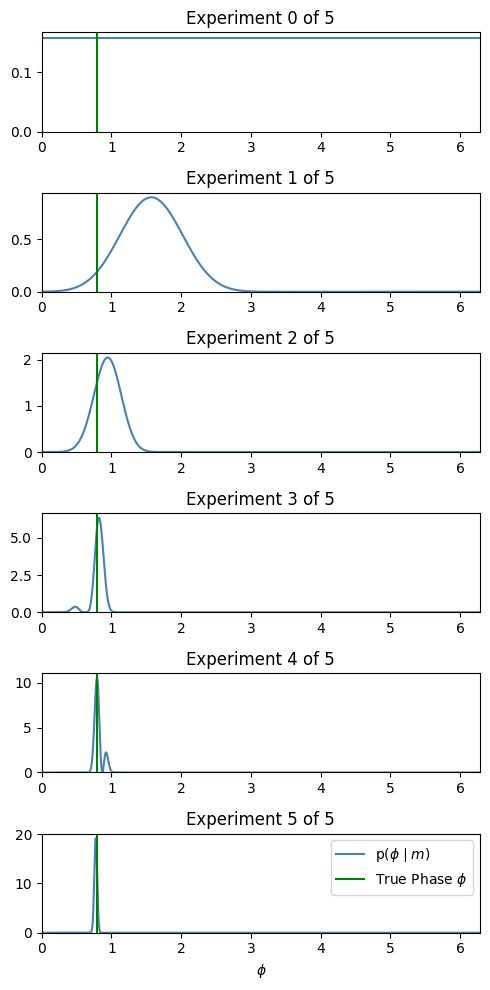

In [17]:
pdf_linsp = jnp.linspace(0, 2 * jnp.pi, 1000)

fig, axes = plt.subplots(num_experiments + 1, figsize=(5, 10))
for i in range(num_experiments + 1):
    axes[i].plot(pdf_linsp,phayes.pdf(pdf_linsp, states[i]), c='steelblue', label=f'p($\phi \mid m)$')
    axes[i].axvline(true_phi, color='green', label=r'True Phase $\phi$')
    axes[i].set_title(f"Experiment {i} of {num_experiments}")
    axes[i].set_xlim(0, 2 * jnp.pi)
    axes[i].set_ylim(0, axes[i].get_ylim()[1])
axes[-1].set_xlabel(r'$\phi$')
axes[-1].legend()
fig.tight_layout()